In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,"
os.environ["HTTP_PROXY"] = "http://127.0.0.1:7890"
os.environ["HTTPS_PROXY"] = "http://127.0.0.1:7890"
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms

import numpy as np
from PIL import Image
from timm.models import create_model
np.random.seed(1307)

Extension horovod.torch has not been built: /home/fzj/.local/lib/python3.8/site-packages/horovod/torch/mpi_lib_v2.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.


In [2]:
real_image_dir = "data/WSSS4LUAD/1.training"
mosaic_2_112_dir = "data/WSSS4LUAD/mosaic_2_112/img"
mosaic_2_112_disc_dir = "data/WSSS4LUAD/mosaic_2_112/disc_img_r18_e5"

N = 1000
real_image_list = np.random.choice([i for i in os.listdir(real_image_dir) if i.endswith('.png')], size=N, replace=False)
mosaic_2_112_images_list = np.random.choice(os.listdir(mosaic_2_112_dir), size=N, replace=False)
mosaic_2_112_disc_images_list = np.random.choice(os.listdir(mosaic_2_112_disc_dir), size=N, replace=False)


In [3]:
model = create_model('inception_v3', pretrained=True)
model.eval()
model.cuda()
model.fc = torch.nn.Identity()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

In [4]:
real_image_fearture_list = []
mosaic_2_112_images = []
mosaic_2_112_disc_images = []

for filename in real_image_list:
    image_path = os.path.join(real_image_dir, filename)
    image = Image.open(image_path)
    image = transform(image)
    with torch.no_grad():
        feature = model(image.cuda().unsqueeze(0)).cpu().numpy()
    real_image_fearture_list.append(feature)

for filename in mosaic_2_112_images_list:
    image_path = os.path.join(mosaic_2_112_dir, filename)
    image = Image.open(image_path)
    image = transform(image)
    with torch.no_grad():
        feature = model(image.cuda().unsqueeze(0)).cpu().numpy()
    mosaic_2_112_images.append(feature)

for filename in mosaic_2_112_disc_images_list:
    image_path = os.path.join(mosaic_2_112_disc_dir, filename)
    image = Image.open(image_path)
    image = transform(image)
    with torch.no_grad():
        feature = model(image.cuda().unsqueeze(0)).cpu().numpy()
    mosaic_2_112_disc_images.append(feature)
    

data = np.concatenate([real_image_fearture_list, mosaic_2_112_images, mosaic_2_112_disc_images])

/home/fzj/.conda/envs/wsss4luad/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/fzj/.conda/envs/wsss4luad/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/fzj/.conda/envs/wsss4luad/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/fzj/.conda/envs/wsss4luad/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/fzj/.conda/envs/wsss4luad/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.wa

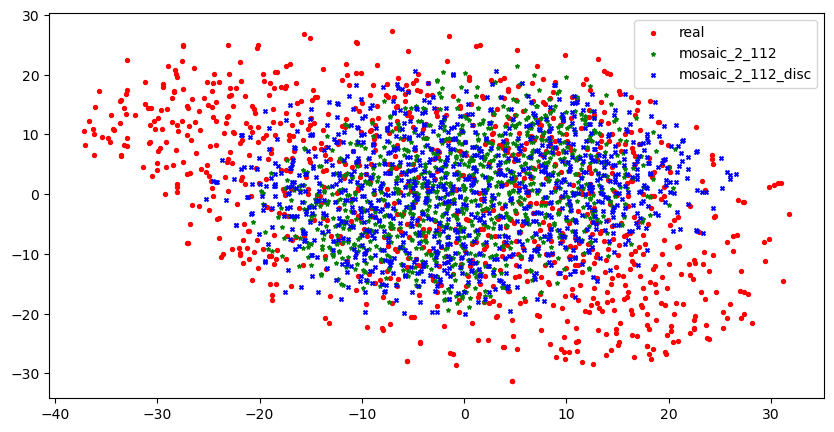

In [7]:
X_tsne = TSNE(n_components=2,random_state=34).fit_transform(data.squeeze(1))

plt.figure(figsize=(10, 5))
for i in range(3):
    cmap = ['red', 'green', 'blue'][i]
    name = ['real', 'mosaic_2_112', 'mosaic_2_112_disc'][i]
    # x = X_tsne[i:i+N]
    df = [real_image_fearture_list, mosaic_2_112_images, mosaic_2_112_disc_images][i]
    x = TSNE(n_components=2,random_state=34).fit_transform(np.array(df).squeeze(1))
    plt.scatter(x[:, 0], x[:, 1], c=cmap, label=name, marker=['o', '*', 'x'][i], s=8 )
plt.legend()
plt.show()